In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# easier access to tensorflow distributions
ds = tf.contrib.distributions

According to the [MINUIT documentation](https://root.cern.ch/download/minuit.pdf) parameters with a defined range are transformed non-linearly for minimization. In the [ROOT/MINUIT2 code base](https://github.com/root-project/root/tree/master/math/minuit2/inc/Minuit2) we can see that three different transformatios are applied:
* SinParameterTransformation when doubly bounded
* SqrtLowParameterTransformation when singly upper bounded 
* SqrtUpParameterTransformation when singly lower bounded

This also requires some tricky transformations to the covariance matrix based on the transformation Jacobian.

In [2]:
# upper bound
up_bound = tf.placeholder(dtype=tf.float32, shape=(),
                          name="up_bound")
# lower bound
dw_bound = tf.placeholder(dtype=tf.float32, shape=(),
                          name="dw_bound")
# variable we want to transform ([n_batch] for vectorized eval)
var_values = tf.placeholder(dtype=tf.float32, shape=(None,),
                            name="var_values")

In [3]:
class SinParamTransform(object):
    
    @staticmethod
    def ext2int(values, upper, lower):
        with tf.variable_scope("sin_param_transform_ext2int_{}".format(values.op.name)):
            return tf.asin((2.*(values - lower)/(upper-lower)-1.))
    
    @staticmethod
    def int2ext(values, upper, lower):
        with tf.variable_scope("sin_param_transform_int2ext_{}".format(values.op.name)):
            return lower+0.5*(upper-lower)*(tf.sin(values)+1.)
    
    @staticmethod
    def dint2ext(values, upper, lower):
        with tf.variable_scope("sin_param_transform_dint2ext_{}".format(values.op.name)):
            return 0.5*(upper-lower)*tf.cos(values)
        
class SqrtUpParamTransform(object):
    
    @staticmethod
    def ext2int(values, upper):
        with tf.variable_scope("sqrt_up_transform_ext2int_{}".format(values.op.name)):
            return tf.sqrt((upper-values+1.)**2-1.)
    
    @staticmethod
    def int2ext(values, upper):
        with tf.variable_scope("sqrt_up_transform_int2ext_{}".format(values.op.name)):
            return upper+1.-tf.sqrt(values**2+1.)
    
    @staticmethod
    def dint2ext(values, upper):
        with tf.variable_scope("sqrt_up_transform_dint2ext_{}".format(values.op.name)):
            return -values/tf.sqrt(values**2+1.)
        
class SqrtDwParamTransform(object):
    
    @staticmethod
    def ext2int(values, lower):
        with tf.variable_scope("sqrt_dw_transform_ext2int_{}".format(values.op.name)):
            return tf.sqrt((values-lower+1.)**2-1.)
    
    @staticmethod
    def int2ext(values, lower):
        with tf.variable_scope("sqrt_dw_transform_int2ext_{}".format(values.op.name)):
            return lower-1.+tf.sqrt(values**2+1.)
    
    @staticmethod
    def dint2ext(values, lower):
        with tf.variable_scope("sqrt_dw_transform_dint2ext_{}".format(values.op.name)):
            return values/tf.sqrt(values**2+1.)

In [4]:
var_values_arr = np.linspace(-6.,6., 101, endpoint=True, dtype=np.float32 )
feed_dict = { var_values : var_values_arr,
              up_bound : np.array(3.,dtype=np.float32),
              dw_bound : np.array(-3.,dtype=np.float32)}

sin_transform_ext2int = SinParamTransform.ext2int(var_values, up_bound, dw_bound)
sin_transform_int2ext = SinParamTransform.int2ext(sin_transform_ext2int, up_bound, dw_bound)
sin_transform_dint2ext = tf.gradients(sin_transform_int2ext,sin_transform_ext2int)[0]
sin_transform_dint2ext_true = SinParamTransform.dint2ext(sin_transform_ext2int, up_bound, dw_bound)

sqrt_up_transform_ext2int = SqrtUpParamTransform.ext2int(var_values, up_bound)
sqrt_up_transform_int2ext = SqrtUpParamTransform.int2ext(sqrt_up_transform_ext2int, up_bound)
sqrt_up_transform_dint2ext = tf.gradients(sqrt_up_transform_int2ext,sqrt_up_transform_ext2int)[0]
sqrt_up_transform_dint2ext_true = SqrtUpParamTransform.dint2ext(sqrt_up_transform_ext2int, up_bound)

sqrt_dw_transform_ext2int = SqrtDwParamTransform.ext2int(var_values, dw_bound)
sqrt_dw_transform_int2ext = SqrtDwParamTransform.int2ext(sqrt_dw_transform_ext2int, dw_bound)
sqrt_dw_transform_dint2ext = tf.gradients(sqrt_dw_transform_int2ext,sqrt_dw_transform_ext2int)[0]
sqrt_dw_transform_dint2ext_true = SqrtDwParamTransform.dint2ext(sqrt_dw_transform_ext2int, dw_bound)


with tf.Session() as sess:
    sin_transform_arrs =  sess.run([sin_transform_ext2int,
                                    sin_transform_int2ext,
                                    sin_transform_dint2ext,
                                    sin_transform_dint2ext_true],
                                    feed_dict=feed_dict)
    sqrt_up_transform_arrs = sess.run([sqrt_up_transform_ext2int,
                                       sqrt_up_transform_int2ext,
                                       sqrt_up_transform_dint2ext,
                                       sqrt_up_transform_dint2ext_true],
                                     feed_dict=feed_dict)
    sqrt_dw_transform_arrs = sess.run([sqrt_dw_transform_ext2int,
                                       sqrt_dw_transform_int2ext,
                                       sqrt_dw_transform_dint2ext,
                                       sqrt_dw_transform_dint2ext_true],
                                     feed_dict=feed_dict)

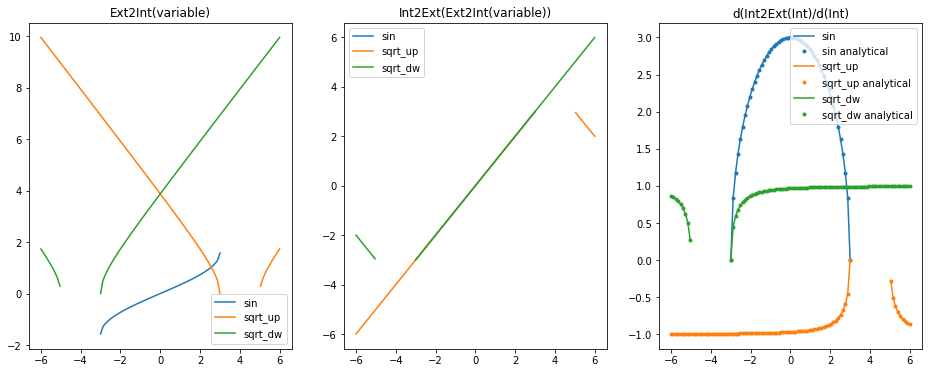

In [5]:
fig, axs = plt.subplots(1,3,figsize=(16,6))

t_names = ["sin","sqrt_up","sqrt_dw"]
t_colors = ["C0","C1","C2"]

axs[0].set_title("Ext2Int(variable)")
axs[1].set_title("Int2Ext(Ext2Int(variable))")
axs[2].set_title("d(Int2Ext(Int)/d(Int)")

for i, transform_arrs in enumerate([sin_transform_arrs,
                                    sqrt_up_transform_arrs,
                                    sqrt_dw_transform_arrs]):
    name = t_names[i]
    color = t_colors[i]
    axs[0].plot(var_values_arr, transform_arrs[0], label=name)
    axs[1].plot(var_values_arr, transform_arrs[1], label=name)
    axs[2].plot(var_values_arr, transform_arrs[2], "{}-".format(color),
                label=name)
    axs[2].plot(var_values_arr, transform_arrs[2], "{}.".format(color),
                label="{} analytical".format(name))

for ax in  axs:
    ax.legend(loc="best")

fig;

In [6]:
var_values_arr = np.linspace(-10.,10., 101, endpoint=True, dtype=np.float32 )

feed_dict = { var_values : var_values_arr,
              up_bound : np.array(3.,dtype=np.float32),
              dw_bound : np.array(-3.,dtype=np.float32)}

sin_inv_transform_int2ext = SinParamTransform.int2ext(var_values, up_bound, dw_bound)
sqrt_up_inv_transform_int2ext = SqrtUpParamTransform.int2ext(var_values, up_bound)
sqrt_dw_inv_transform_int2ext = SqrtDwParamTransform.int2ext(var_values, dw_bound)


with tf.Session() as sess:
    sin_inv_transform_arrs =  sess.run([sin_inv_transform_int2ext],
                                        feed_dict=feed_dict)
    sqrt_up_inv_transform_arrs =  sess.run([sqrt_up_inv_transform_int2ext],
                                        feed_dict=feed_dict)
    sqrt_dw_inv_transform_arrs =  sess.run([sqrt_dw_inv_transform_int2ext],
                                            feed_dict=feed_dict)

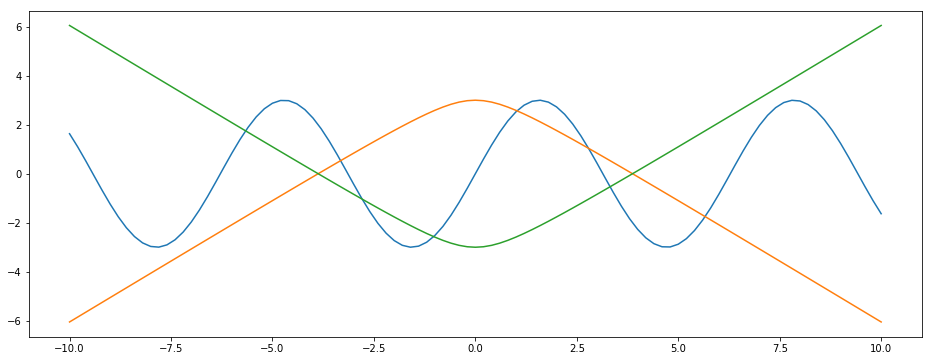

In [7]:
fig, axs = plt.subplots(1,1,figsize=(16,6))

t_names = ["sin","sqrt_up","sqrt_dw"]
t_colors = ["C0","C1","C2"]

axs.plot(var_values_arr, sin_inv_transform_arrs[0])
axs.plot(var_values_arr, sqrt_up_inv_transform_arrs[0])
axs.plot(var_values_arr, sqrt_dw_inv_transform_arrs[0])

fig;

With these transformations, now the likelihood and its derivatives can be evaluated in unconstrained space and then the optima and the error matrices can be transformed back with a bit of care the the initial parameters.